<a href="https://colab.research.google.com/github/jimtoberfest/options_notebooks/blob/main/synthetic_variance_swap.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#installs and imports

In [355]:
!pip install yfinance -q
!pip install opstrat -q

In [356]:
import yfinance as yf
import pandas as pd
import numpy as np
import opstrat as op


#Stock / Options Chain Download

In [357]:
upst = yf.Ticker("UPST")

In [358]:
upst_hist = upst.history(period="1d")
upst_hist.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2021-12-31,153.229996,156.899994,151.070007,151.300003,2543200,0,0


##Set underlying Price Variable

In [359]:
#underlying Price

S = upst_hist.iloc[0]['Close']
S

151.3000030517578

#build OTM Options Chain

In [360]:
upst_expiries = upst.options

upst.opt = upst.option_chain(upst_expiries[3])

In [361]:
puts_otm = upst.opt.puts[upst.opt.puts['strike']<= S]
puts_otm['type'] = 'p'
calls_otm = upst.opt.calls[upst.opt.calls['strike']>= S]
calls_otm['type'] = 'c'

In [362]:
options_list = [puts_otm,calls_otm]
options_final = pd.concat(options_list)

In [363]:
options_final['mid'] = ((options_final['ask'] - options_final['bid']) / 2) + options_final['bid']


#Determine Strike Weights

In [389]:
# Weighting of the Strikes according to:   K_wt =(c / K^2)


options_final['weighted_K'] = 1 / (options_final['strike']**2)

# options_final['weighted_K'] = 500 / (options_final['strike'])

options_final.tail()

,contractSymbol,lastTradeDate,strike,lastPrice,bid,ask,change,percentChange,volume,openInterest,impliedVolatility,inTheMoney,contractSize,currency,type,mid,weighted_K,calc_value,delta,gamma,theta,vega,dollar_gamma
29,UPST220128C00245000,2021-12-31 20:40:37+00:00,245.0,0.60,0.55,0.90,-0.20,-24.999998,8.0,3,0.965332,False,REGULAR,USD,c,0.725,0.000017,0.729884,0.047842,0.002461,-0.072101,0.041722,0.563410
30,UPST220128C00250000,2021-12-31 20:58:55+00:00,250.0,0.40,0.40,0.95,-0.35,-46.666668,20.0,56,0.984375,False,REGULAR,USD,c,0.675,0.000016,0.680427,0.044303,0.002269,-0.069116,0.039225,0.519437
31,UPST220128C00255000,2021-12-30 17:24:28+00:00,255.0,0.70,0.20,0.90,0.00,0.000000,3.0,6,0.979492,False,REGULAR,USD,c,0.550,0.000015,0.553086,0.037079,0.001974,-0.059517,0.033948,0.451796
32,UPST220128C00260000,2021-12-28 16:38:01+00:00,260.0,0.94,0.10,0.85,0.00,0.000000,1.0,24,0.984863,False,REGULAR,USD,c,0.475,0.000015,0.478325,0.032475,0.001760,-0.053667,0.030446,0.402981
33,UPST220128C00265000,2021-12-31 17:00:53+00:00,265.0,0.65,0.00,0.60,-0.20,-23.529417,13.0,6,0.945313,False,REGULAR,USD,c,0.300,0.000014,0.303224,0.022388,0.001345,-0.037765,0.022321,0.307805


In [390]:
# bsm=op.black_scholes(K=135, St=S, r=1.01, t=28, 
#                      v=81, type=type)
# bsm['value']['option value']
# bsm

In [391]:
# options_final['calc_value'] = options_final.apply(lambda x: bsm(x['strike'], S, 1.01, 28, x['impliedVolatility'],x['type']),axis=1)

#Calculate Greeks; Static Price, Vol, DTE

In [392]:
# S = upst_hist.iloc[0]['Close']

values = []
delta = []
gamma = []
theta = []
vega = []

for i in range(len(options_final)):
  K = options_final.iloc[i]['strike']
  St = S
  r = 1.01
  t = 28
  v = options_final.iloc[i]['impliedVolatility']
  type = options_final.iloc[i]['type']
  
  # print("inputs: ", K, St, r, t, v, type)

  n = op.black_scholes(K=K, St=S, r=r, t=t, 
                     v=v*100, type=type)

  val = n['value']['option value']
  de = n['greeks']['delta']
  ga = n['greeks']['gamma']
  th = n['greeks']['theta']
  ve = n['greeks']['vega']
  
  
  
  values.append(val)
  delta.append(de)
  gamma.append(ga)
  theta.append(th)
  vega.append(ve)


In [393]:
options_final['calc_value'] = values
options_final['delta'] = delta
options_final['gamma'] = gamma
options_final['theta'] = theta
options_final['vega'] = vega
options_final['dollar_gamma'] = (options_final['gamma']/100) * S**2

In [394]:
options_final.head(3)

,contractSymbol,lastTradeDate,strike,lastPrice,bid,ask,change,percentChange,volume,openInterest,impliedVolatility,inTheMoney,contractSize,currency,type,mid,weighted_K,calc_value,delta,gamma,theta,vega,dollar_gamma
0,UPST220128P00075000,2021-12-21 16:41:40+00:00,75.0,0.65,0.0,0.30,0.0,0.0,1.0,3,1.136723,False,REGULAR,USD,p,0.150,0.000178,0.159654,-0.009101,0.000520,-0.020657,0.010198,0.116943
1,UPST220128P00080000,2021-12-27 15:41:47+00:00,80.0,0.27,0.0,0.30,0.0,0.0,1.0,1,1.041020,False,REGULAR,USD,p,0.150,0.000156,0.160644,-0.009982,0.000615,-0.020506,0.011056,0.138439
2,UPST220128P00085000,2021-12-30 18:13:06+00:00,85.0,0.17,0.0,0.35,0.0,0.0,1.0,2,0.972657,False,REGULAR,USD,p,0.175,0.000138,0.189292,-0.012354,0.000793,-0.023057,0.013308,0.178350


#Select Strikes for Synth Var Swap (Manual)

In [395]:
v_ops = options_final.copy()

In [396]:
# K_select = [75,90,110,130,150,170,190,210,230]
# v_ops = options_final[options_final['strike'].isin(K_select)]


In [397]:
v_ops['wt_K'] = round(v_ops['weighted_K'])

v_ops['wt_K'] = v_ops['weighted_K']

#Calc Position Greeks

In [398]:
v_ops['pos_delta'] = v_ops['delta'] * v_ops['wt_K'] * -1
v_ops['pos_gamma'] = v_ops['gamma'] * v_ops['wt_K'] * -1
v_ops['pos_theta'] = v_ops['theta'] * v_ops['wt_K'] * -1
v_ops['pos_vega'] = v_ops['vega'] * v_ops['wt_K'] * -1
v_ops['pos_dollar_gamma'] = v_ops['dollar_gamma'] * v_ops['wt_K']

v_ops['pos_premium'] = v_ops['calc_value'] * v_ops['wt_K']

In [399]:
v_ops.head(10)

,contractSymbol,lastTradeDate,strike,lastPrice,bid,ask,change,percentChange,volume,openInterest,impliedVolatility,inTheMoney,contractSize,currency,type,mid,weighted_K,calc_value,delta,gamma,theta,vega,dollar_gamma,wt_K,pos_delta,pos_gamma,pos_theta,pos_vega,pos_dollar_gamma,pos_premium
0,UPST220128P00075000,2021-12-21 16:41:40+00:00,75.0,0.65,0.00,0.30,0.00,0.000000,1.0,3,1.136723,False,REGULAR,USD,p,0.150,0.000178,0.159654,-0.009101,0.000520,-0.020657,0.010198,0.116943,0.000178,0.000002,-9.239947e-08,0.000004,-0.000002,0.000021,0.000028
1,UPST220128P00080000,2021-12-27 15:41:47+00:00,80.0,0.27,0.00,0.30,0.00,0.000000,1.0,1,1.041020,False,REGULAR,USD,p,0.150,0.000156,0.160644,-0.009982,0.000615,-0.020506,0.011056,0.138439,0.000156,0.000002,-9.613828e-08,0.000003,-0.000002,0.000022,0.000025
2,UPST220128P00085000,2021-12-30 18:13:06+00:00,85.0,0.17,0.00,0.35,0.00,0.000000,1.0,2,0.972657,False,REGULAR,USD,p,0.175,0.000138,0.189292,-0.012354,0.000793,-0.023057,0.013308,0.178350,0.000138,0.000002,-1.097119e-07,0.000003,-0.000002,0.000025,0.000026
3,UPST220128P00090000,2021-12-29 19:58:23+00:00,90.0,0.49,0.10,0.45,0.00,0.000000,1.0,20,0.949219,False,REGULAR,USD,p,0.275,0.000123,0.297296,-0.018882,0.001169,-0.032384,0.019156,0.263076,0.000123,0.000002,-1.443489e-07,0.000004,-0.000002,0.000032,0.000037
4,UPST220128P00095000,2021-12-30 15:51:50+00:00,95.0,0.46,0.15,0.55,0.00,0.000000,1.0,9,0.896485,False,REGULAR,USD,p,0.350,0.000111,0.377381,-0.024602,0.001548,-0.038239,0.023957,0.348354,0.000111,0.000003,-1.715499e-07,0.000004,-0.000003,0.000039,0.000042
5,UPST220128P00100000,2021-12-30 18:23:21+00:00,100.0,0.45,0.30,0.50,0.00,0.000000,5.0,31,0.830080,False,REGULAR,USD,p,0.400,0.000100,0.434265,-0.029923,0.001969,-0.041676,0.028208,0.442985,0.000100,0.000003,-1.968823e-07,0.000004,-0.000003,0.000044,0.000043
6,UPST220128P00105000,2021-12-30 20:36:07+00:00,105.0,0.67,0.50,1.25,0.00,0.000000,13.0,30,0.875001,False,REGULAR,USD,p,0.875,0.000091,0.938197,-0.055232,0.003070,-0.072198,0.046370,0.690814,0.000091,0.000005,-2.784839e-07,0.000007,-0.000004,0.000063,0.000085
7,UPST220128P00110000,2021-12-31 18:08:51+00:00,110.0,0.90,0.85,1.20,-0.07,-7.216500,8.0,72,0.812990,False,REGULAR,USD,p,1.025,0.000083,1.100786,-0.067662,0.003872,-0.078578,0.054340,0.871310,0.000083,0.000006,-3.200404e-07,0.000006,-0.000004,0.000072,0.000091
8,UPST220128P00115000,2021-12-31 20:50:02+00:00,115.0,1.46,1.25,1.85,0.21,16.800003,13.0,24,0.806154,False,REGULAR,USD,p,1.550,0.000076,1.659782,-0.095928,0.005083,-0.101367,0.070724,1.143622,0.000076,0.000007,-3.843299e-07,0.000008,-0.000005,0.000086,0.000126
9,UPST220128P00120000,2021-12-31 20:50:02+00:00,120.0,2.16,1.95,3.10,0.43,24.855495,19.0,32,0.829347,False,REGULAR,USD,p,2.525,0.000069,2.680972,-0.137931,0.006395,-0.134919,0.091538,1.438795,0.000069,0.000010,-4.440725e-07,0.000009,-0.000006,0.000100,0.000186


In [400]:
print("  delta: ",v_ops['pos_delta'].sum()*100,'\n',
' gamma: ',v_ops['pos_gamma'].sum()*100,'\n',
' theta: ',v_ops['pos_theta'].sum()*100,'\n',
'  vega: ', v_ops['pos_vega'].sum()*100, '\n',
'$gamma:', v_ops['pos_dollar_gamma'].sum())


  delta:  0.002264164700332025 
  gamma:  -0.0009350157922246157 
  theta:  0.020211392322655706 
   vega:  -0.013496213575268421 
 $gamma: 0.0021037855325053856


In [401]:
v_ops['pos_premium'].sum()*100

0.5345232376338761

#Graph Terminal Payout Risk (manual)

In [402]:
9,6,4,3,2,2,1,1,1   #how many of each strike

(9, 6, 4, 3, 2, 2, 1, 1, 1)

In [403]:
op1={'op_type': 'p', 'strike': 90, 'tr_type': 's', 'op_pr': .30}
op2={'op_type': 'p', 'strike': 110, 'tr_type': 's', 'op_pr': 1.00}
op3={'op_type': 'p', 'strike': 130, 'tr_type': 's', 'op_pr': 4.65}
op4={'op_type': 'p', 'strike': 150, 'tr_type': 's', 'op_pr': 12.75}
op5={'op_type': 'c', 'strike': 170, 'tr_type': 's', 'op_pr': 7.00}
op6={'op_type': 'c', 'strike': 190, 'tr_type': 's', 'op_pr': 3.45}
op7={'op_type': 'c', 'strike': 210, 'tr_type': 's', 'op_pr': 1.70}
op8={'op_type': 'c', 'strike': 230, 'tr_type': 's', 'op_pr': .85}
op11={'op_type': 'p', 'strike': 75, 'tr_type': 's', 'op_pr': .15}

# Using a live fence as a heage as the op.multiplotter cant do a true delta hedge
op9={'op_type': 'p', 'strike': 150, 'tr_type': 'b', 'op_pr': 12.75}  #hedge
op10={'op_type': 'c', 'strike': 170, 'tr_type': 's', 'op_pr': 7.00}  #hedge


op_list=[op11,op11,op11,op11,op11,op11,op11,op11,op11,op1,op1,op1,op1,op1,op1,op2,op2,op2,op2, op3,op3,op3, op4,op4, op5,op5, op6, op7, op8]

hedged_op_list=[op11,op11,op11,op11,op11,op11,op11,op11,op11,op1,op1,op1,op1,op1,op1,op2,op2,op2,op2, op3,op3,op3, op4,op4, op5,op5, op6, op7, op8, op9, op10, op6]



##Graphs

In [404]:
# op.multi_plotter(spot=S,spot_range=(40), op_list=op_list)

In [405]:
# op.multi_plotter(spot=S,spot_range=(40), op_list=hedged_op_list)

#Create Better Graphs with Greek Risks over Price and Time

In [406]:
# To Do, see above title
'''
Loop 1. set price, IGNORE outer price loop for now...!!!!!
Loop 2. set day, add .0001 to each time step to get expiry calc w/o having a zero
          calc options
          multiply by position
          sum pos risks
          record in df: dte, value, delta, gamma, theta, vega

'''

'\nLoop 1. set price, IGNORE outer price loop for now...!!!!!\nLoop 2. set day, add .0001 to each time step to get expiry calc w/o having a zero\n          calc options\n          multiply by position\n          sum pos risks\n          record in df: dte, value, delta, gamma, theta, vega\n\n'

In [407]:
# from numpy.lib.shape_base import vsplit
# Create DF to hold output
columns = ['dte', 'value', 'delta', 'gamma', 'theta', 'vega']
holding = pd.DataFrame(columns=columns)


# Days Loop
for days in range(1, 29):
  days = days + .001


  values = []
  delta = []
  gamma = []
  theta = []
  vega = []


  #Strikes Loop
  for i in range(len(v_ops)):
    K = v_ops.iloc[i]['strike']
    St = S
    r = 1.01
    t = days
    v = v_ops.iloc[i]['impliedVolatility']
    type = v_ops.iloc[i]['type']
    
    # print("inputs: ", K, St, r, t, v, type)

    n = op.black_scholes(K=K, St=S, r=r, t=t, 
                      v=v*100, type=type)

    
    # How many of each option o we need for the position
    pos_multi = v_ops.iloc[i]['wt_K']

    val = n['value']['option value'] * pos_multi
    de = n['greeks']['delta'] * pos_multi
    ga = n['greeks']['gamma'] * pos_multi
    th = n['greeks']['theta'] * pos_multi
    ve = n['greeks']['vega'] * pos_multi
    
    values.append(val)
    delta.append(de)
    gamma.append(ga)
    theta.append(th)
    vega.append(ve)

  vs = sum(values) * 100
  ds = sum(delta) * 100
  gs = sum(gamma) * 100
  ts = sum(theta) * 100
  vegs = sum(vega) * 100

  t_list = [days,vs,ds,gs,ts,vegs]
  # print(t_list)
  holding = holding.append(pd.Series(t_list, index=holding.columns), ignore_index=True)


In [408]:

holding['dollar_gamma'] = (holding['gamma']/100) * S**2

holding

,dte,value,delta,gamma,theta,vega,dollar_gamma
0,1.001,0.019808,-0.002178,0.000885,-0.017853,0.000442,0.199026
1,2.001,0.037684,-0.002162,0.000889,-0.017918,0.000887,0.200097
2,3.001,0.055653,-0.002152,0.000893,-0.018020,0.001337,0.200999
3,4.001,0.073720,-0.002142,0.000896,-0.018111,0.001790,0.201607
4,5.001,0.091872,-0.002131,0.000898,-0.018191,0.002245,0.202050
5,6.001,0.110100,-0.002118,0.000900,-0.018266,0.002702,0.202430
6,7.001,0.128403,-0.002105,0.000901,-0.018341,0.003161,0.202804
7,8.001,0.146783,-0.002091,0.000903,-0.018421,0.003624,0.203202
8,9.001,0.165246,-0.002078,0.000905,-0.018506,0.004091,0.203635
9,10.001,0.183797,-0.002066,0.000907,-0.018597,0.004561,0.204105


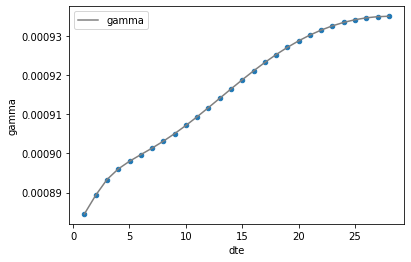

In [409]:
ax = holding.plot.scatter(x='dte', y='gamma')
holding.plot.line(x='dte', y='gamma', ax=ax, color='grey')

In [410]:
columns = ['price', 'value', 'delta', 'gamma', 'theta', 'vega']
price_holding = pd.DataFrame(columns=columns)

S = 150
# Price Loop
for price in range(140,160):
  
  values = []
  delta = []
  gamma = []
  theta = []
  vega = []


  #Strikes Loop
  for i in range(len(v_ops)):
    K = v_ops.iloc[i]['strike']
    St = price
    r = 1.01
    t = 28
    v = v_ops.iloc[i]['impliedVolatility']
    type = v_ops.iloc[i]['type']
    
    # print("inputs: ", K, St, r, t, v, type)

    n = op.black_scholes(K=K, St=St, r=r, t=t, 
                      v=v*100, type=type)

    
    # How many of each option o we need for the position
    pos_multi = v_ops.iloc[i]['wt_K']

    val = n['value']['option value'] * pos_multi
    de = n['greeks']['delta'] * pos_multi
    ga = n['greeks']['gamma'] * pos_multi
    th = n['greeks']['theta'] * pos_multi
    ve = n['greeks']['vega'] * pos_multi
    
    values.append(val)
    delta.append(de)
    gamma.append(ga)
    theta.append(th)
    vega.append(ve)

  vs = sum(values) * 100
  ds = sum(delta) * 100
  gs = sum(gamma) * 100
  ts = sum(theta) * 100
  vegs = sum(vega) * 100

  t_list = [price,vs,ds,gs,ts,vegs]
  # print(t_list)
  price_holding = price_holding.append(pd.Series(t_list, index=price_holding.columns), ignore_index=True)


In [411]:
price_holding['dollar_gamma'] = (price_holding['gamma']/100) * S**2
price_holding

,price,value,delta,gamma,theta,vega,dollar_gamma
0,140.0,0.606250,-0.012323,0.001080,-0.020476,0.013633,0.243028
1,141.0,0.594464,-0.011251,0.001065,-0.020450,0.013623,0.239557
2,142.0,0.583743,-0.010193,0.001049,-0.020424,0.013612,0.236131
3,143.0,0.574072,-0.009152,0.001034,-0.020397,0.013600,0.232752
4,144.0,0.565435,-0.008125,0.001020,-0.020371,0.013587,0.229419
5,145.0,0.557818,-0.007112,0.001005,-0.020344,0.013574,0.226132
6,146.0,0.551206,-0.006114,0.000991,-0.020318,0.013560,0.222891
7,147.0,0.545585,-0.005131,0.000976,-0.020291,0.013545,0.219695
8,148.0,0.540940,-0.004161,0.000962,-0.020265,0.013529,0.216545
9,149.0,0.537257,-0.003206,0.000949,-0.020238,0.013513,0.213439


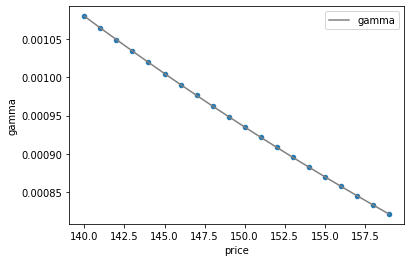

In [412]:
ax = price_holding.plot.scatter(x='price', y='gamma')
price_holding.plot.line(x='price', y='gamma', ax=ax, color='grey')